<h1> Классификатор логистической регрессии по данным о доходах переписи населения </h1>

В этой работе мы проанализируем набор данных переписи населения из репозитория машинного обучения UCI.
https://archive.ics.uci.edu/ml/datasets/census+income

Набор данных содержит три файла:
* Adult.data : набор обучающих данных
* Adult.names : описание набора данных
* Adult.test : тестовый набор данных

Мы будем использовать логистическую регрессию для построения классификатора. В целом, любой проект машинного обучения требует следующих шагов:
* Постановка проблемы
* Исследование данных
* Обучение модели
* Настройка модели
* Сохранение модель

Итак, приступим.

<h2>Постановка проблемы</h2>

Данные содержат анонимную информацию, такую как возраст, профессия, образование, рабочий класс и т . д. Цель состоит в том, чтобы научить бинарный классификатор прогнозировать доход, который имеет два возможных значения «> 50 000» и «< 50 000». В наборе данных 48842 экземпляра и 14 атрибутов. Сначала мы импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import os
from pandas.api.types import CategoricalDtype
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

<h2>Загрузка данных</h2>

Мы скачали данные и поместили их в папку data. Для их считывания мы будем использовать pandas-овскую функцию read_csv.

In [2]:
columns = ["age", "workClass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship",
           "race", "sex", "capital_gain", "capital_loss", "hours_per_week",
           "native_country", "income"]
train_data = pd.read_csv('adult.data', names=columns, 
             sep=' *, *', na_values='?', engine='python')
test_data  = pd.read_csv('adult.test', names=columns, 
             sep=' *, *', skiprows=1, na_values='?', engine='python')

In [3]:
train_data.head()

,age,workClass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Есть некоторые пробелы до и после значений данных. Чтобы обрезать все пробелы, мы используем разделитель ‘ *, *’. В тестовом наборе данных есть странная первая строка, поэтому мы пропускаем строку, используя skiprows=1. Отсутствующие значения в наборе данных обозначены '?'
Далее мы изучим данные. Это важный шаг перед тем, как приступить к построению модели.

<h2>Исследование данных</h2>

Посмотрим на тренировочный набор данных

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workClass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Наблюдение:
* В обучающем наборе данных 32561 выборка .
* В наборе данных есть как категориальные, так и числовые столбцы.
* В столбцах workClass , occupation , native-country пропущены значения

Аналогично, для тестового набора данных
* Есть 16281 образец
* Нет пропущенных значений

Давайте посмотрим числовые и категориальные данные с помощью некоторых визуализаций.

Обработаем числовые столбцы. Используем select_dtypes для отборки числовых столбцов.

In [5]:
num_attributes = train_data.select_dtypes(include=['int'])
print(num_attributes.columns)

Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week'],
      dtype='object')


Переменные age , hours-per-week говорят сами за себя.
* fnlwgt: вес
* education-num: общее количество лет обучения
* capital-gain/capital-loss: прирост/убыток капитала

fnlwgt не связан с целевым переменным income и будет удален перед построением модели.

Провизуализируем данные

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fnlwgt'}>],
       [<Axes: title={'center': 'education_num'}>,
        <Axes: title={'center': 'capital_gain'}>],
       [<Axes: title={'center': 'capital_loss'}>,
        <Axes: title={'center': 'hours_per_week'}>]], dtype=object)

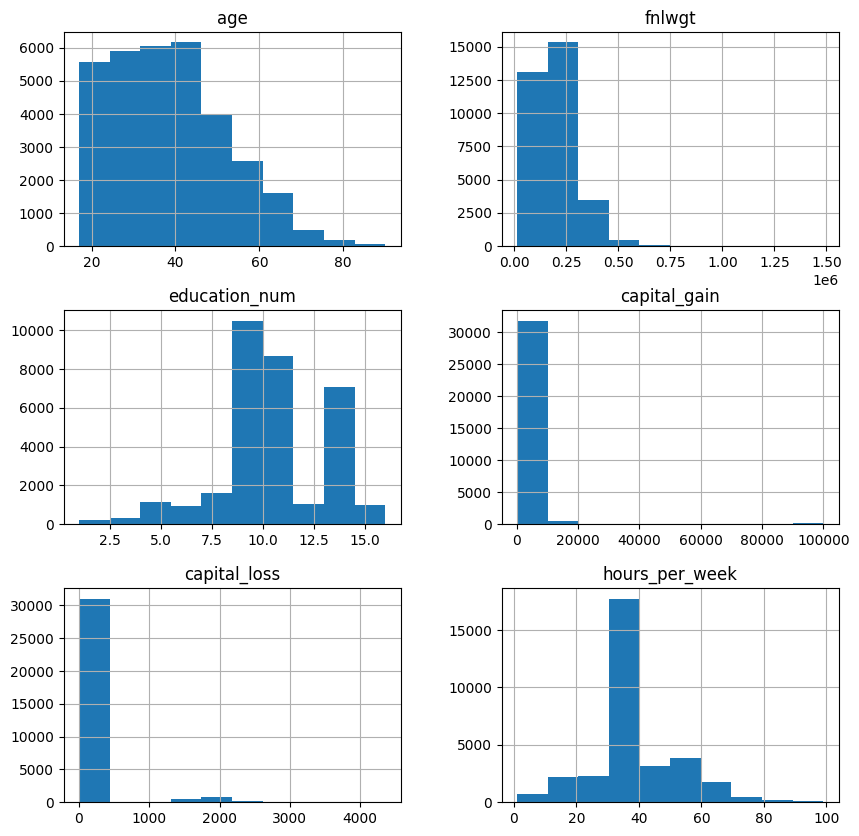

In [6]:
num_attributes.hist(figsize=(10,10))

Более подробную информацию о данных можно получить, используя train_data.describe().

In [7]:
train_data.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


* Ни один из числовых атрибутов не имеет пропущенных значений
* Значения находятся в разных шкалах. Многие модели машинного обучения требуют, чтобы значения были в одном масштабе. Мы будем использовать StandardScaler из библиотеки sklearn для масштабирования функций.


Обработаем категориальные столбцы

In [8]:
cat_attributes = train_data.select_dtypes(include=['object'])
print(cat_attributes.columns)

Index(['workClass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'income'],
      dtype='object')


Провизуализиуем их, используя countplot из пакета seaborn.

<Axes: xlabel='count', ylabel='workClass'>

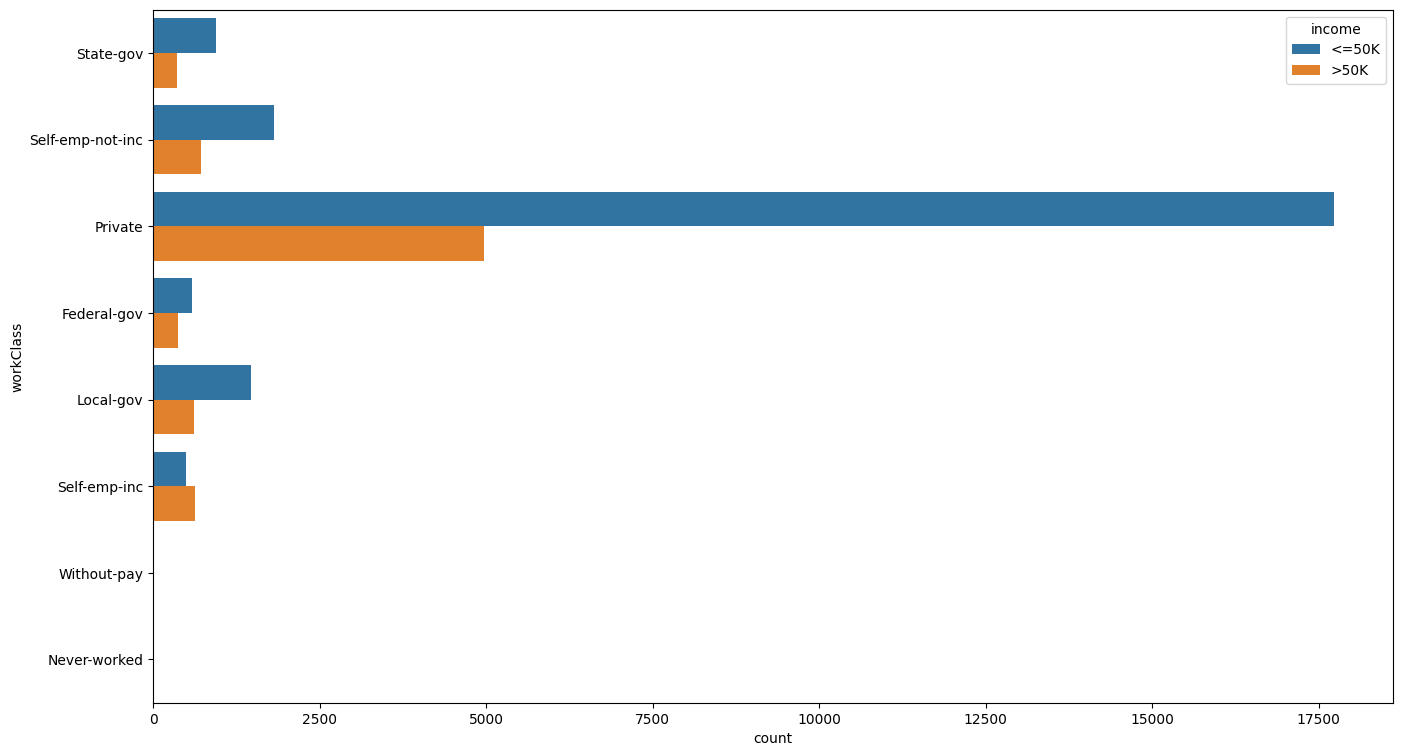

In [9]:
sns.countplot(y='workClass', hue='income', data = cat_attributes)

<Axes: xlabel='count', ylabel='occupation'>

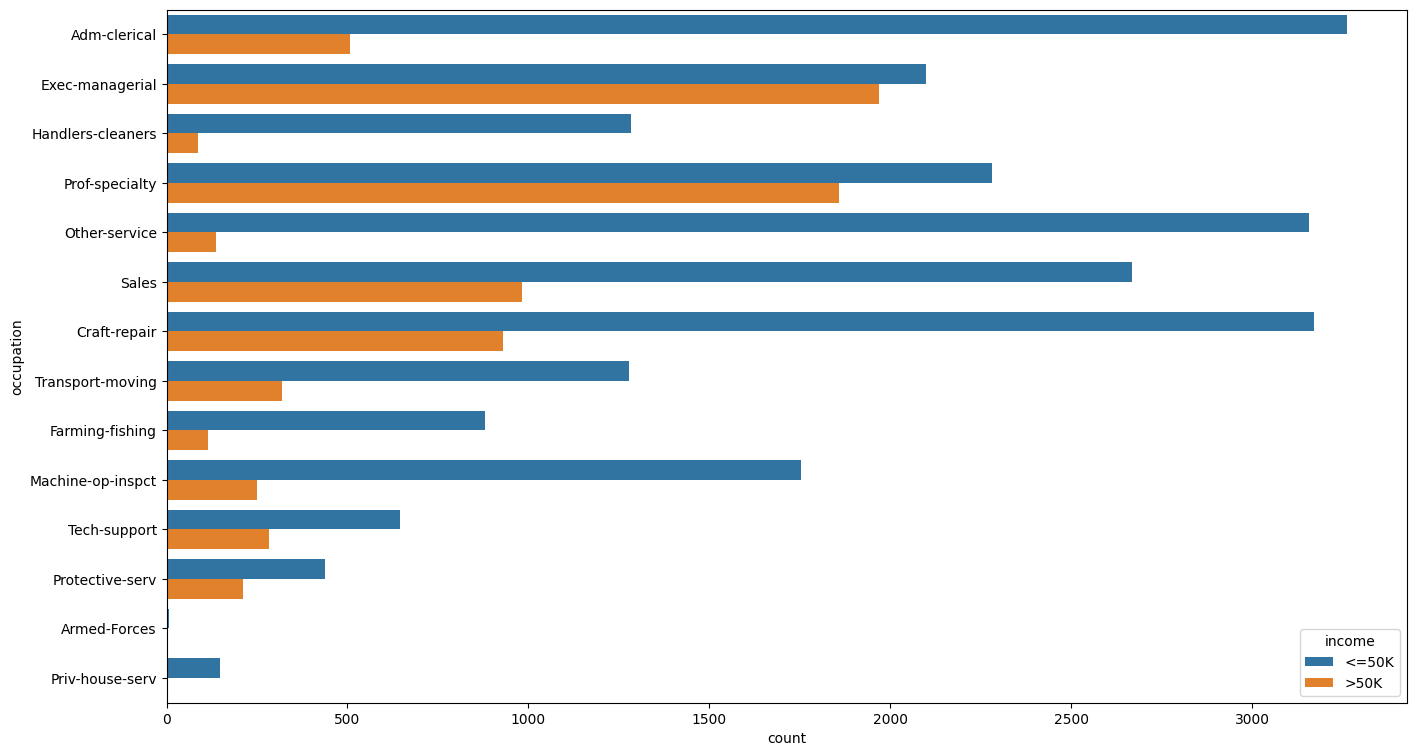

In [10]:
sns.countplot(y='occupation', hue='income', data = cat_attributes)

* Столбец «education» — это просто строковое представление столбца «education-num». Мы опустим колонку education .
* Переменные workClass , occupation , native-country имеют пропущенные значения. Мы заменим отсутствующие значения в каждом столбце наиболее часто встречающимся значением этого столбца.

Нам нужно по-разному обрабатывать числовые и категориальные атрибуты. Числовые атрибуты необходимо масштабировать, тогда как для категориальных столбцов нам нужно заполнить пропущенные значения, а затем закодировать категориальные значения в числовые значения. Чтобы применить эту последовательность преобразований, мы будем использовать класс Pipeline sklearn. Мы также создадим собственные преобразователи, которые можно будет напрямую использовать с Pipeline.

Напишем собственный преобразователь, который будет выбирать соответствующие атрибуты (числовые или категориальные).

In [11]:
train_data.head()

,age,workClass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
XY_train = pd.get_dummies(train_data[['age', 'income']]) \
.drop(columns = ['income_>50K'],  axis=1) \
.rename(columns={'income_<=50K':'income'})
X_train = XY_train[['age']]
Y_train = XY_train['income']

In [13]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [14]:
model.coef_

array([[-0.03953168]])

In [15]:
model.intercept_

array([2.74403934])

In [16]:
from scipy.special import expit

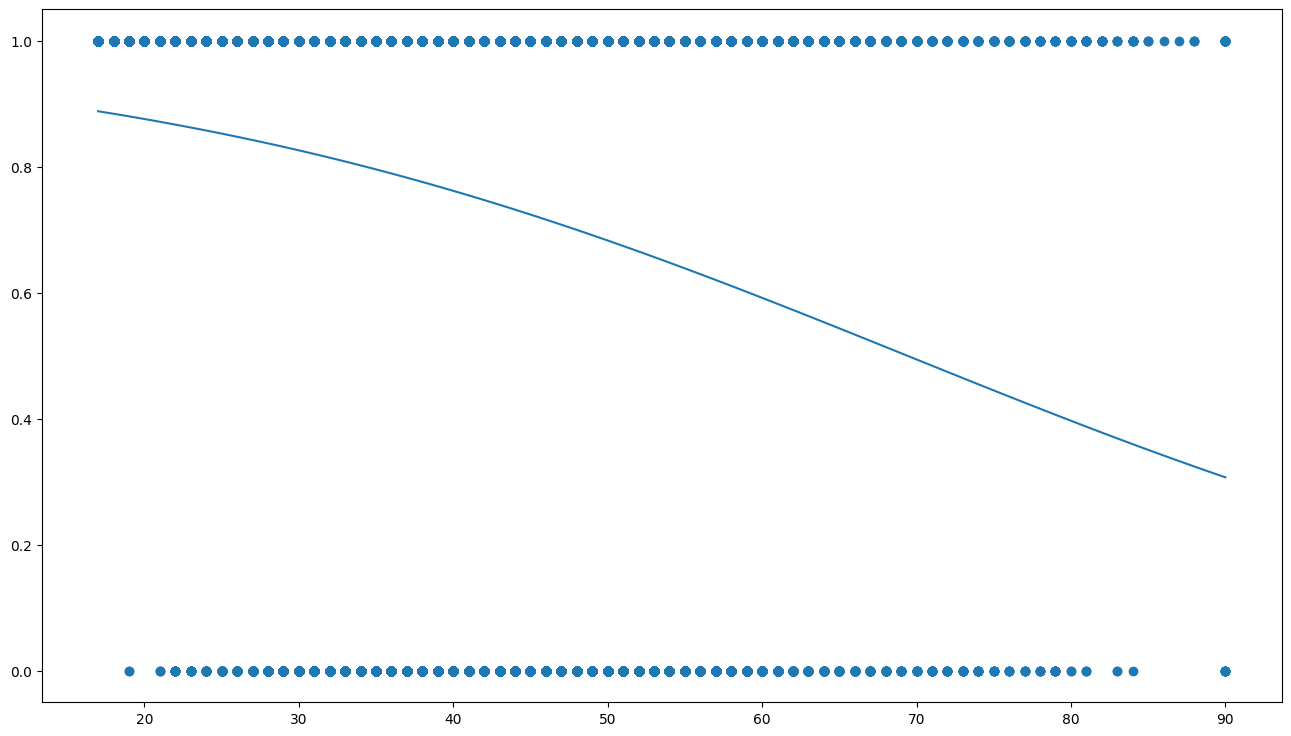

In [17]:
x_test1 = np.linspace(17, 90, 100)
y_test1 = x_test1*model.coef_+model.intercept_
sigmoid = expit(y_test1)
plt.scatter(X_train, Y_train)
plt.plot(x_test1, sigmoid.ravel())

In [18]:
print(X_train.head())
model.predict_proba(X_train.head(5))

   age
0   39
1   50
2   38
3   53
4   28


array([[0.23106564, 0.76893436],
       [0.31702983, 0.68297017],
       [0.22411665, 0.77588335],
       [0.34324642, 0.65675358],
       [0.16285292, 0.83714708]])

In [19]:
model.predict([[50]])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([ True])

In [20]:
XY_test = pd.get_dummies(test_data[['age', 'income']]) \
.drop(columns = ['income_>50K.'],  axis=1) \
.rename(columns={'income_<=50K.':'income'})
X_test = XY_test[['age']]
Y_test = XY_test['income']

In [21]:
model.score(X_test, Y_test)

0.7486640869725447